In [32]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [33]:
dir_path='prepared_dataset'

#training dataset
x_train=np.load(os.path.join(dir_path,'train_images.npy'))
y_train=np.load(os.path.join(dir_path,'train_labels.npy'))

#cross validation dataset
x_cv=np.load(os.path.join(dir_path,'cross_validation_images.npy'))
y_cv=np.load(os.path.join(dir_path,'cross_validation_labels.npy'))

#test dataset
x_test=np.load(os.path.join(dir_path,'test_images.npy'))
y_test=np.load(os.path.join(dir_path,'test_labels.npy'))

In [34]:
y_train=np.expand_dims(y_train,axis=1)
y_cv=np.expand_dims(y_cv,axis=1)
y_test=np.expand_dims(y_test,axis=1)

In [35]:
print(f"shape of X_train,y_train = {x_train.shape},{y_train.shape} \n"+
      f"shape of X_cv,y_cv = {x_cv.shape},{y_cv.shape} \n"+
      f"shape of X_test,y_test = {x_test.shape},{y_test.shape}")

shape of X_train,y_train = (445, 278, 278, 3),(445, 1) 
shape of X_cv,y_cv = (56, 278, 278, 3),(56, 1) 
shape of X_test,y_test = (56, 278, 278, 3),(56, 1)


In [36]:
features=278*278*3

x_train_reshaped=x_train.reshape((445,features))
x_cv_reshaped=x_cv.reshape((56,features))
x_test_reshaped=x_test.reshape((56,features))

print("After reshaping : ")
print(f"shape of X_train,y_train = {x_train_reshaped.shape},{y_train.shape} \n"+
      f"shape of X_cv,y_cv = {x_cv_reshaped.shape},{y_cv.shape} \n"+
      f"shape of X_test,y_test = {x_test_reshaped.shape},{y_test.shape}")

After reshaping : 
shape of X_train,y_train = (445, 231852),(445, 1) 
shape of X_cv,y_cv = (56, 231852),(56, 1) 
shape of X_test,y_test = (56, 231852),(56, 1)


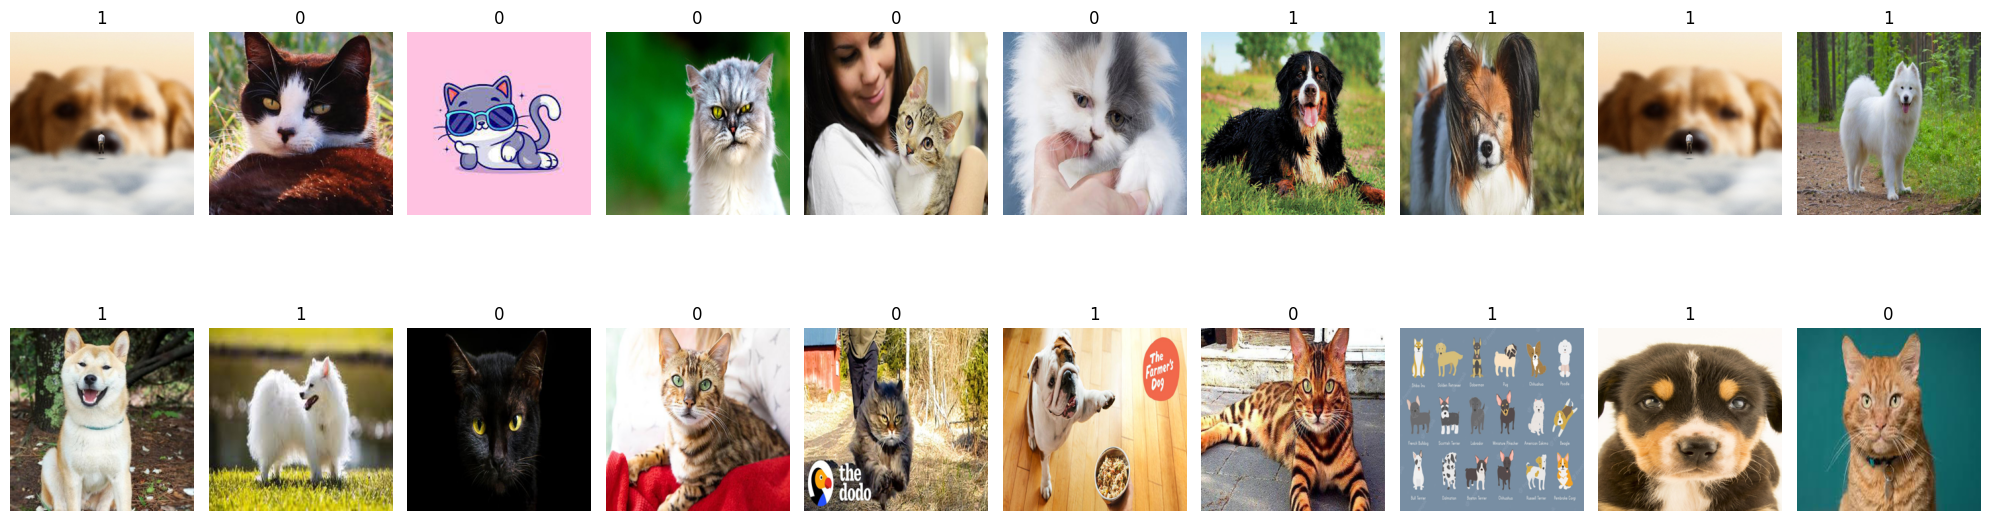

In [37]:
fig,axis=plt.subplots(2,10,figsize=(20,10))
np.random.seed(42)
for i in range(2):
    for j in range(10):
        index=np.random.randint(x_train.shape[0])
        axis[i,j].imshow(x_train[index].reshape(278,278,3))
        axis[i,j].set_title(y_train[index].squeeze())
        axis[i,j].set_axis_off()
        plt.tight_layout()
        


In [38]:
scaler=StandardScaler()
x_train_reshaped_scaled=scaler.fit_transform(x_train_reshaped)
x_cv_reshaped_scaled=scaler.transform(x_cv_reshaped)

In [39]:

model = Sequential([
    tf.keras.Input((231852,)),
    Dense(units=640, activation='relu', name='layer_1',kernel_regularizer=l2(0.01)),
    Dense(units=325, activation='relu', name='layer_2',kernel_regularizer=l2(0.01)),
    Dense(units=120, activation='relu', name='layer_3',kernel_regularizer=l2(0.01)),
    Dense(units=2, activation='linear', name='layer_4')
], name='model_2')

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 640)               148385920 
                                                                 
 layer_2 (Dense)             (None, 325)               208325    
                                                                 
 layer_3 (Dense)             (None, 120)               39120     
                                                                 
 layer_4 (Dense)             (None, 2)                 242       
                                                                 
Total params: 148633607 (566.99 MB)
Trainable params: 148633607 (566.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
model.compile(optimizer=Adam(0.01),loss=SparseCategoricalCrossentropy(from_logits=True))

history=model.fit(x_train_reshaped_scaled,y_train,epochs=50)

Epoch 1/50
14/14 [==============================] - 24s 2s/step - loss: 55.9882
Epoch 2/50
14/14 [==============================] - 23s 2s/step - loss: 31.7314
Epoch 3/50
14/14 [==============================] - 23s 2s/step - loss: 11.5166
Epoch 4/50
14/14 [==============================] - 23s 2s/step - loss: 6.5391
Epoch 5/50
14/14 [==============================] - 23s 2s/step - loss: 20.0270
Epoch 6/50
14/14 [==============================] - 23s 2s/step - loss: 7.6075
Epoch 7/50
14/14 [==============================] - 23s 2s/step - loss: 3.7883
Epoch 8/50
14/14 [==============================] - 23s 2s/step - loss: 2.5871
Epoch 9/50
14/14 [==============================] - 23s 2s/step - loss: 2.1237
Epoch 10/50
14/14 [==============================] - 23s 2s/step - loss: 1.8988
Epoch 11/50
14/14 [==============================] - 22s 2s/step - loss: 1.7745
Epoch 12/50
14/14 [==============================] - 23s 2s/step - loss: 1.7747
Epoch 13/50
14/14 [==========================

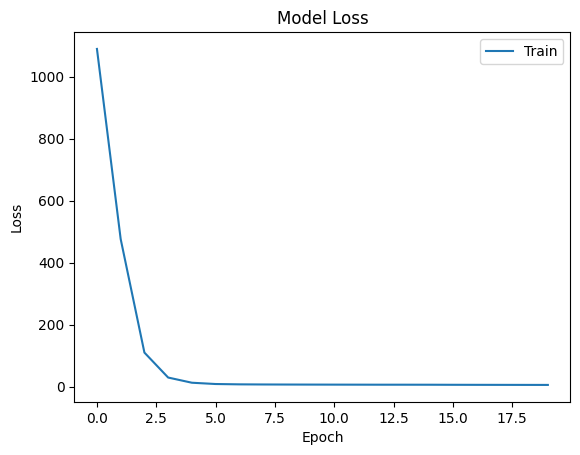

In [41]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [42]:
threshold=0.5

logits_train = model.predict(x_train_reshaped_scaled)
yhat_train = tf.nn.softmax(logits_train, axis=1).numpy()
prob_train = np.argmax(yhat_train, axis=1)
J_train = np.mean(prob_train != y_train)

# J_cv
logits_cv = model.predict(x_cv_reshaped_scaled)
yhat_cv = tf.nn.softmax(logits_cv, axis=1).numpy()
prob_cv = np.argmax(yhat_cv, axis=1)
J_cv = np.mean(prob_cv != y_cv)


print(f"J_train : {J_train} \n"+f"J_cv : {J_cv}")

2/2 [==============================] - 0s 79ms/step
J_train : 0.5012801413962883 
J_cv : 0.4897959183673469


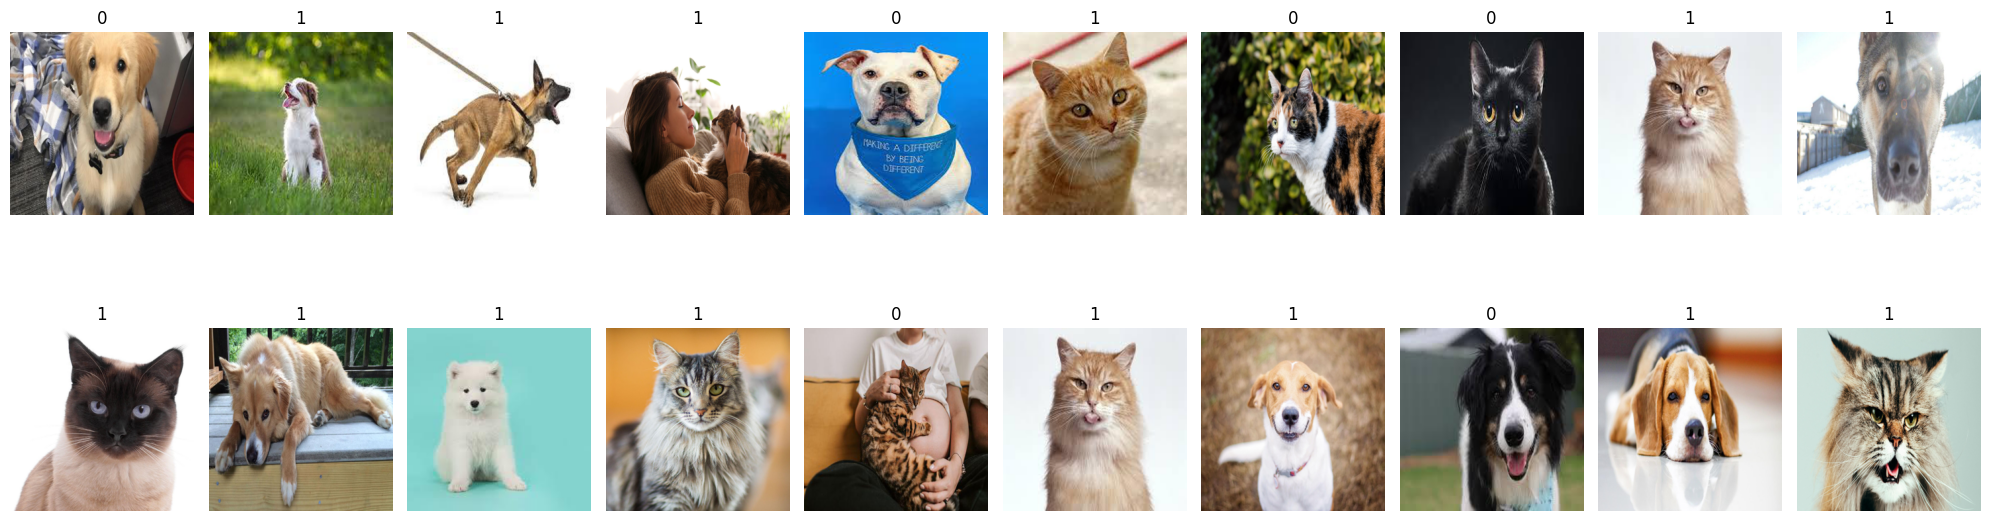

In [45]:
fig,axis=plt.subplots(2,10,figsize=(20,10))
for i in range(2):
    for j in range(10):
        index=np.random.randint(x_cv.shape[0])
        axis[i,j].imshow(x_cv[index].reshape(278,278,3))
        axis[i,j].set_title(prob_cv[index].squeeze())
        axis[i,j].set_axis_off()
        plt.tight_layout()

<Axes: >

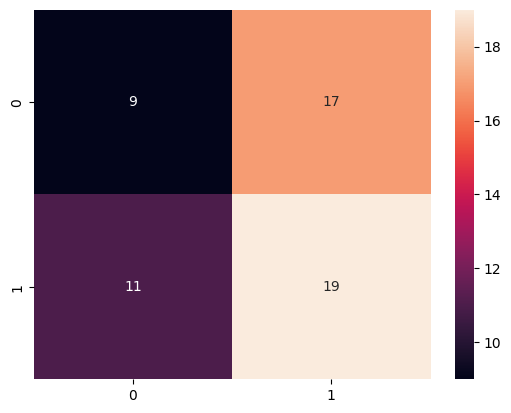

In [47]:
sns.heatmap(confusion_matrix(y_cv,prob_cv),annot=True)